<a href="https://colab.research.google.com/github/YCCS-Summer-2023-DDNMA/project/blob/main/team_members/Abraham_Linzer/Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online learning of an MLP Classifier using conditional moments Gaussian filter



Online training of an multilayer perceptron (MLP) classifier using conditional moments Gaussian filter (CMGF).


We perform sequential (recursive) Bayesian inference for the parameters of a binary MLP classifier.
To do this, we treat the parameters of the model as the unknown hidden states.
We assume that these are approximately constant over time (we add a small amount of Gaussian drift,
for numerical stability.)
The graphical model is shown below.

![RLS](https://github.com/probml/dynamax/blob/main/docs/figures/rlsDgm.png?raw=true)

The model has the following form

\begin{align*}
\theta_t &=  \theta_{t-1} + q_t, \; q_t \sim N(0, 0.01 I)  \\
y_t &\sim Ber(\sigma(h(x_t, \theta_t))
\end{align*}

This is a generalized Gaussian SSM, where the observation model is non-linear and non-Gaussian.

To perform approximate inferece, using the  conditional moments Gaussian filter (CMGF).
We approximate the relevant integrals using the extended Kalman filter.
For more details, see sec 8.7.7 of [Probabilistic Machine Learning: Advanced Topics](https://probml.github.io/pml-book/book2.html).

Video of training: https://gist.github.com/petergchang/9441b853b889e0b47d0622da8f7fe2f6


## Setup

In [ ]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [ ]:
print_verbose = False

In [ ]:
from dynamax.generalized_gaussian_ssm import ParamsGGSSM, EKFIntegrals
from dynamax.generalized_gaussian_ssm import conditional_moments_gaussian_filter

In [ ]:
try:
    import flax.linen as nn
except ModuleNotFoundError:
    print('installing flax')
    %pip install -qq flax
import flax.linen as nn

In [ ]:
from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import jax
import random
import seaborn as sns
import jax.numpy as jnp
import numpy as np
import jax.random as jr
from jax.flatten_util import ravel_pytree

In [ ]:
# Helper function that visualizes 2d posterior predictive distribution
def plot_posterior_predictive(ax, X, Y, title, Xspace=None, Zspace=None, cmap=cm.rainbow):
    if Xspace is not None and Zspace is not None:
        ax.contourf(*(Xspace.T), (Zspace.T[0]), cmap=cmap, levels=50)
        ax.axis('off')
    colors = ['red' if y else 'blue' for y in Y]
    ax.scatter(*X.T, c=colors, edgecolors='black', s=50)
    ax.set_title(title)
    return ax

## Create data

First, we generate a binary spiral data.

In [ ]:
# Generate spiral dataset
# Adapted from https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
def generate_spiral_dataset(key=0, num_per_class=250, zero_var=1., one_var=1., shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key1, key2, key3, key4 = jr.split(key, 4)

    theta = jnp.sqrt(jr.uniform(key1, shape=(num_per_class,))) * 2*jnp.pi
    r = 2*theta + jnp.pi
    generate_data = lambda theta, r: jnp.array([jnp.cos(theta)*r, jnp.sin(theta)*r]).T

    # Data for output zero
    zero_input = generate_data(theta, r) + zero_var * jr.normal(key2, shape=(num_per_class, 2))
    zero_output = jnp.zeros((num_per_class, 1,))

    # Data for output one
    one_input = generate_data(theta, -r) + one_var * jr.normal(key3, shape=(num_per_class, 2))
    one_output = jnp.ones((num_per_class, 1,))

    # Stack the inputs and standardize
    input = jnp.concatenate([zero_input, one_input])
    input = (input - input.mean(axis=0)) / input.std(axis=0)

    # Generate binary output
    output = jnp.concatenate([jnp.zeros(num_per_class), jnp.ones(num_per_class)])

    if shuffle:
        idx = jr.permutation(key4, jnp.arange(num_per_class * 2))
        input, output = input[idx], output[idx]

    return input, output

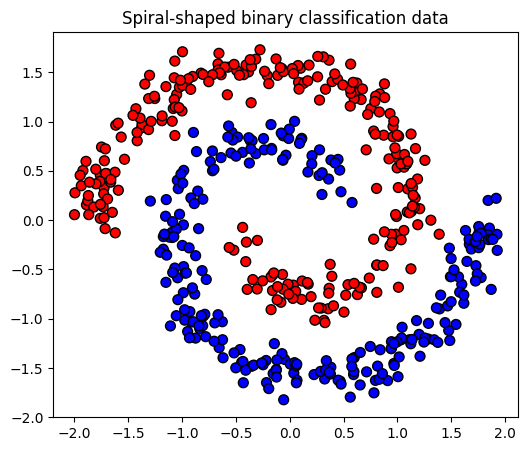

In [ ]:
# Generate data
input, output = generate_spiral_dataset()

# Plot data
fig, ax = plt.subplots(figsize=(6, 5))

title = "Spiral-shaped binary classification data"
plot_posterior_predictive(ax, input, output, title);

## Plotting code

Next, let us define a grid on which we compute the predictive distribution.

In [ ]:
# Define grid limits
xmin, ymin = input.min(axis=0) - 0.1
xmax, ymax = input.max(axis=0) + 0.1

# Define grid
step = 0.1
x_grid, y_grid = jnp.meshgrid(jnp.mgrid[xmin:xmax:step], jnp.mgrid[ymin:ymax:step])
input_grid = jnp.concatenate([x_grid[...,None], y_grid[...,None]], axis=2)

Next, we define a function to that returns the posterior predictive probability for each point in grid.

In [ ]:
# 'binary=True' indicates rounding probabilities to binary outputs
def posterior_predictive_grid(grid, mean, apply, binary=False):
    inferred_fn = lambda x: apply(mean, x)
    fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
    Z = fn_vec(grid)
    if binary:
        Z = jnp.rint(Z)
    return Z

Finally, we define a function that plots the convergence of filtered estimates to the batch MAP estimate.

In [ ]:
def plot_weight_convergence(mean_hist, cov_hist, legend_font_size=14):
    input_dim = mean_hist[-1].shape[0]
    tau_hist = jnp.array([cov_hist[:, i, i] for i in range(input_dim)]).T
    elements = (mean_hist.T, tau_hist.T)
    n_datapoints = len(mean_hist)
    timesteps = jnp.arange(n_datapoints) + 1

    num_weights = 10
    num_cols = 1

    fig, axs = plt.subplots(num_weights, num_cols, figsize=(20, num_weights * 4))

    for k, (wk, Pk) in enumerate(zip(*elements)):
        if k >= num_weights:
            break
        ax = axs[k]
        ax.errorbar(timesteps, wk, jnp.sqrt(Pk), c="blue", label = f"$w_{{{k}}}$")

        ax.set_xlim(1, n_datapoints)

        ax.set_xlabel("ordered sample number", fontsize=15)
        ax.set_ylabel("weight value", fontsize=15)
        ax.tick_params(axis="both", which="major", labelsize=15)
        sns.despine()
        ax.legend(frameon=False, fontsize=legend_font_size)

    # Remove any unused subplots
    if num_weights < len(axs):
        for j in range(num_weights, len(axs)):
            fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


This is a function that prints all of the weights per layer in the model

In [ ]:
def plot_weights(model_dims, mean_hist, cov_hist, num_per_layer):
    mean_T = mean_hist.T
    tau_T = jnp.array([cov_hist[:, i, i] for i in range(mean_hist.shape[-1])]).T.T
    n_datapoints = len(mean_hist)
    timesteps = jnp.arange(n_datapoints) + 1

    num_rows = len(model_dims) - 1
    num_cols = 1

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))

    weights = []
    for i in range(len(model_dims) - 1):
        weights.append(model_dims[i] * model_dims[i+1] + model_dims[i+1])

    sum_weights = [weights[0]]
    for i in range(1, len(weights)):
        new_element = sum_weights[i-1] + weights[i]
        sum_weights.append(new_element)
    sum_weights.insert(0,0)

    for i in range(num_rows):
        ax = axs[i]
        for j in range (num_per_layer):
            idx = random.randint(sum_weights[i], sum_weights[i+1] - 1)
            color = (np.random.random(), np.random.random(), np.random.random())
            ax.set_xlim(1, n_datapoints)
            ax.errorbar(timesteps, mean_T[idx], tau_T[idx], c=color, label = f"$w_{{{idx}}}$")

        ax.set_xlabel("ordered sample number")
        ax.set_ylabel("Weight Value")
        ax.set_title(f"Layer {i + 1}")
        sns.despine()
        ax.legend()

    plt.tight_layout()
    plt.show()

## Define MLP

Finally, we define a generic MLP class that uses a sigmoid activation function.

In [ ]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [ ]:
def get_mlp_flattened_params(model_dims, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    if (print_verbose):
      print(params)
    flat_params, unflatten_fn = ravel_pytree(params)
    if (print_verbose):
      print(flat_params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

## Online Training Using CMGF-EKF

In [ ]:
# Define MLP architecture
input_dim, hidden_dims, output_dim = 2, [16,16], 1
model_dims = [input_dim, *hidden_dims, output_dim]
if (print_verbose):
  print(model_dims)
model, flat_params, unflatten_fn, apply_fn = get_mlp_flattened_params(model_dims)
if (print_verbose):
  print(flat_params.shape)


In [ ]:
# Some model parameters and helper funciton
state_dim, emission_dim = flat_params.size, output_dim
sigmoid_fn = lambda w, x: jax.nn.sigmoid(apply_fn(w, x))
initial_sigma2 = .1
dynamic_sigma = 1e-4

# Run CMGF-EKF to train the MLP Classifier
initial_mean=flat_params
initial_covariance=jnp.eye(state_dim) * initial_sigma2
dynamics_function=lambda w, x: w
dynamics_covariance=jnp.eye(state_dim) * dynamic_sigma
emission_mean_function = lambda w, x: sigmoid_fn(w, x)
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

cmgf_ekf_params = ParamsGGSSM(
     initial_mean = initial_mean,
    initial_covariance = initial_covariance,
    dynamics_function = dynamics_function,
    dynamics_covariance = dynamics_covariance,
    emission_mean_function = emission_mean_function,
    emission_cov_function = emission_cov_function
)
cmgf_ekf_post = conditional_moments_gaussian_filter(cmgf_ekf_params, EKFIntegrals(), output, inputs=input)

# Extract history of filtered weight values
w_means, w_covs = cmgf_ekf_post.filtered_means, cmgf_ekf_post.filtered_covariances

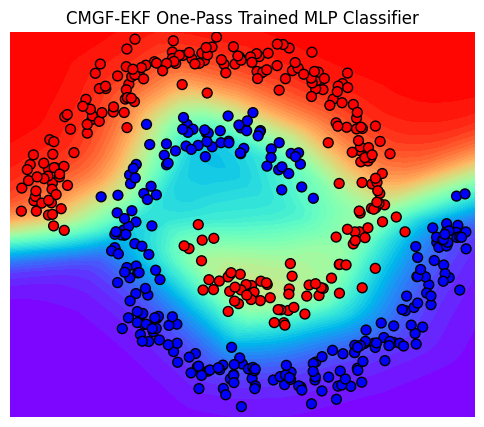

In [ ]:
# Evaluate the trained MLP on input_grid
Z = posterior_predictive_grid(input_grid, w_means[-1], sigmoid_fn, binary=False)

# Plot the final result
fig, ax = plt.subplots(figsize=(6, 5))
title = "CMGF-EKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, input, output, title, input_grid, Z);

In [ ]:
# Weights converging
# plot_weight_convergence(w_means, w_covs)

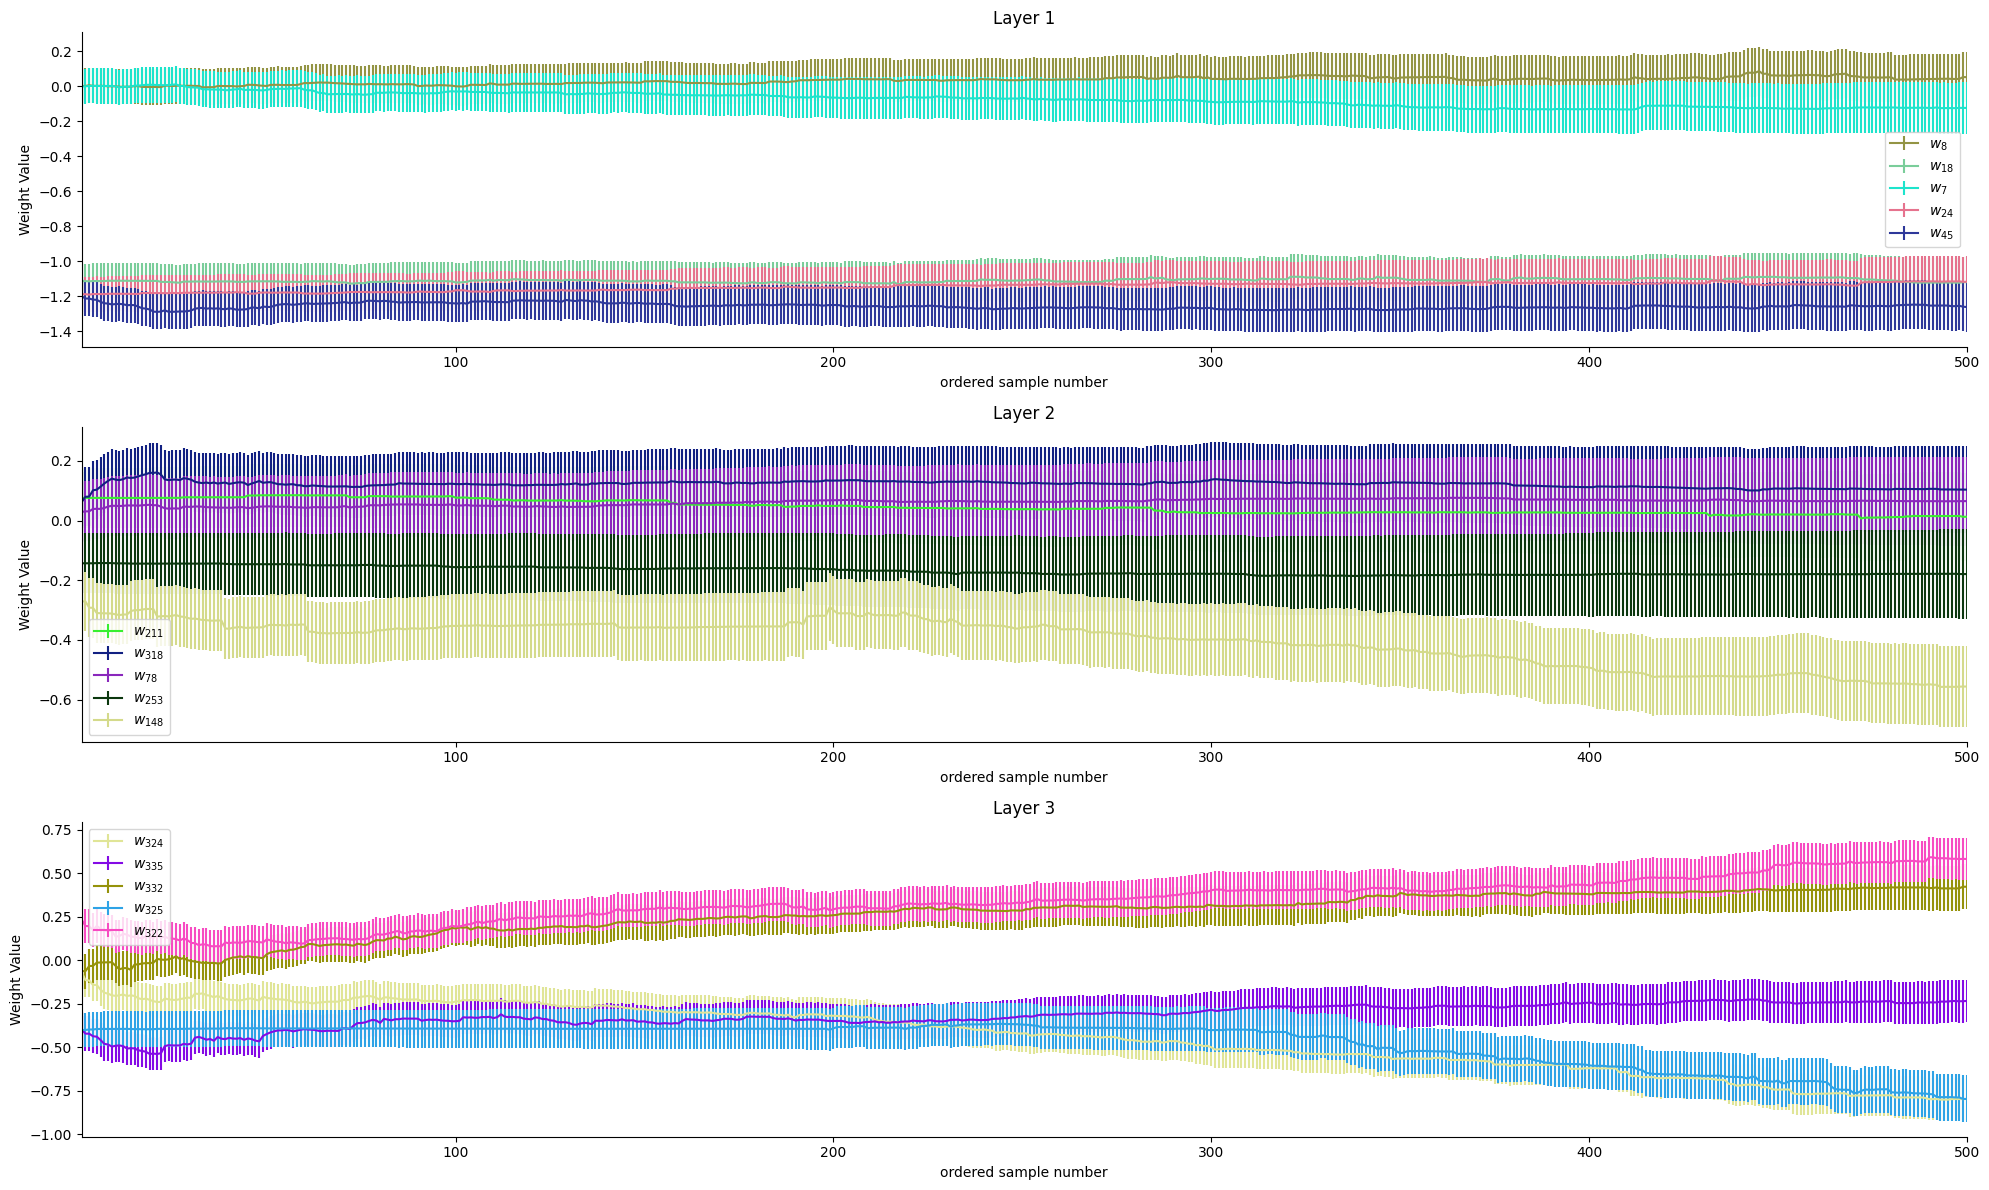

In [ ]:
# Code that prints all weights for first layer, then second layer, then third layer
plot_weights(model_dims, w_means, w_covs, 5)

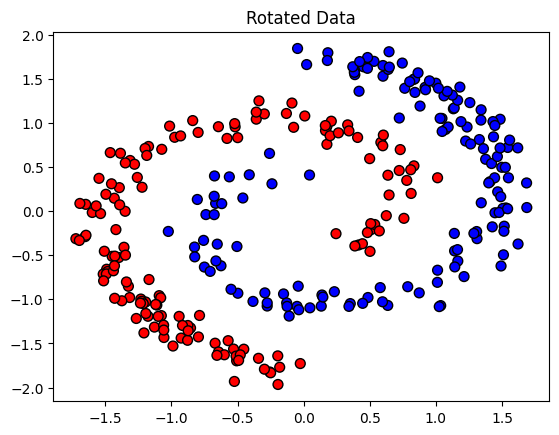

In [ ]:
#Generate the rotated data
def generate_rotated_dataset(rot = 0, key=0, num_per_class=250, zero_var=1., one_var=1., shuffle=True):
  input, output = generate_spiral_dataset(key, num_per_class, zero_var, one_var, shuffle)

  theta = 2.0*jnp.pi *rot/360.0
  rot_mat = jnp.array([[jnp.cos(theta), jnp.sin(theta)], [-jnp.sin(theta), jnp.cos(theta)]])
  input_rot = input @ rot_mat
  # input_rot_with_bias = jnp.concatenate([jnp.ones((num_per_class, 1)), input_rot], axis=1)

  return input_rot, output
# generate some rotated data

rot = 90 # in degrees
input_rot, output_rot = generate_rotated_dataset(rot = rot, num_per_class = 150)

# plot the data

fig, ax = plt.subplots()
title = 'Rotated Data'
plot_posterior_predictive(ax, input_rot, output_rot, title);

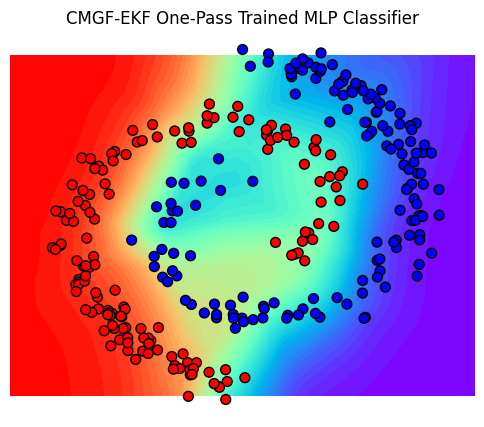

In [ ]:
# Set up params for new model
# max value for prior_val is 20. otherwise the graph goes crazy
prior_var = .1
initial_mean_rot, initial_covariance_rot = w_means[-1], prior_var * w_covs[-1]

cmgf_params2 = ParamsGGSSM(
    initial_mean = initial_mean_rot,
    initial_covariance = initial_covariance_rot,
    dynamics_function = dynamics_function,
    dynamics_covariance = dynamics_covariance,
    emission_mean_function = emission_mean_function,
    emission_cov_function = emission_cov_function
)

cmgf_ekf_post_rot = conditional_moments_gaussian_filter(cmgf_params2, EKFIntegrals(), output_rot, inputs=input_rot)

# Extract history of filtered weight values
w_means_rot, w_covs_rot = cmgf_ekf_post_rot.filtered_means, cmgf_ekf_post_rot.filtered_covariances

# Evaluate the trained MLP on input_grid
Z_rot = posterior_predictive_grid(input_grid, w_means_rot[-1], sigmoid_fn, binary=False)

# Plot the final result
fig, ax = plt.subplots(figsize=(6, 5))
title = "CMGF-EKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, input_rot, output_rot, title, input_grid, Z_rot);

In [ ]:
# plot_weight_convergence(w_means_rot, w_covs_rot)

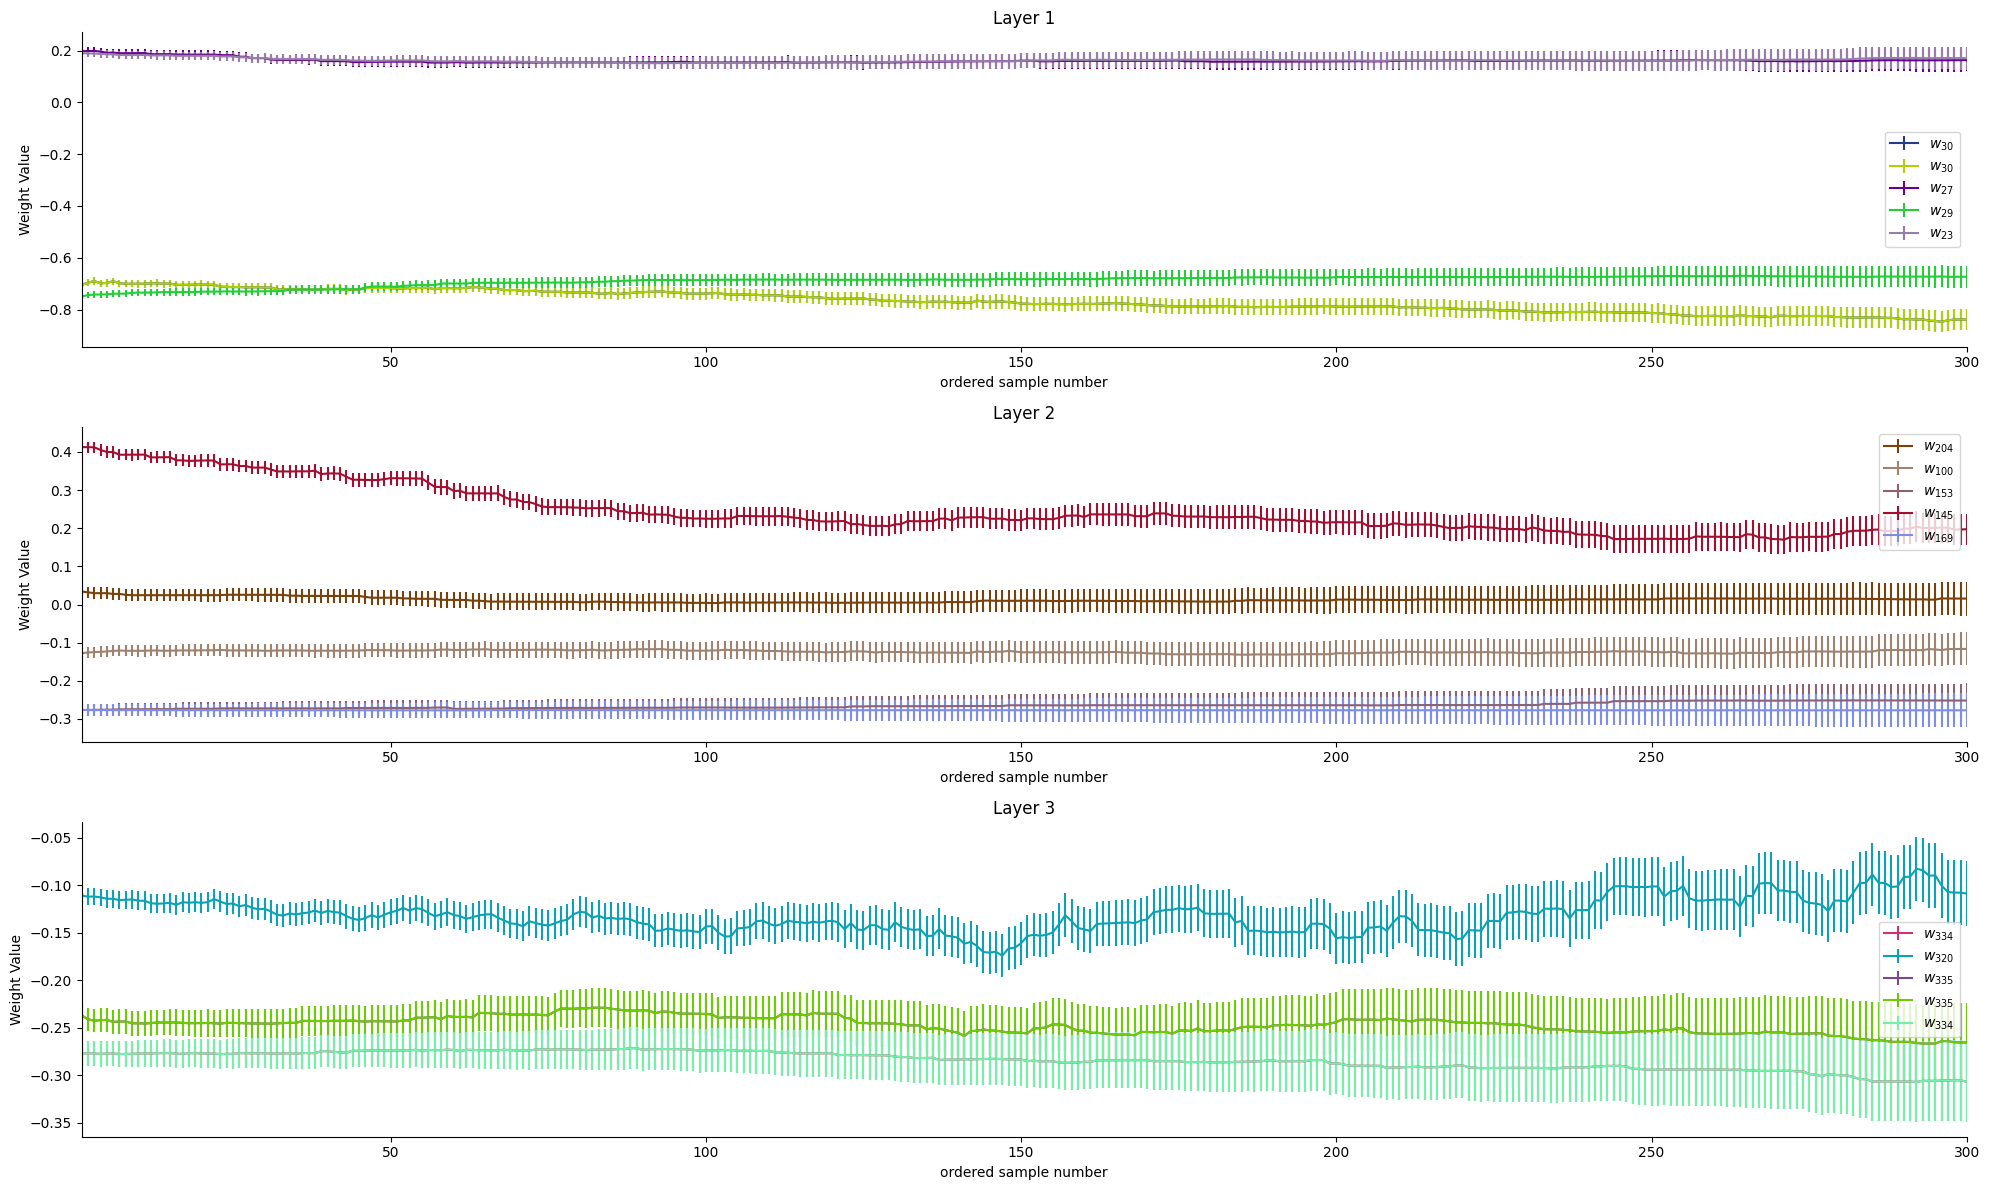

In [ ]:
plot_weights(model_dims, w_means_rot, w_covs_rot, 5)

Next, we visualize the training procedure by evaluating the intermediate steps.

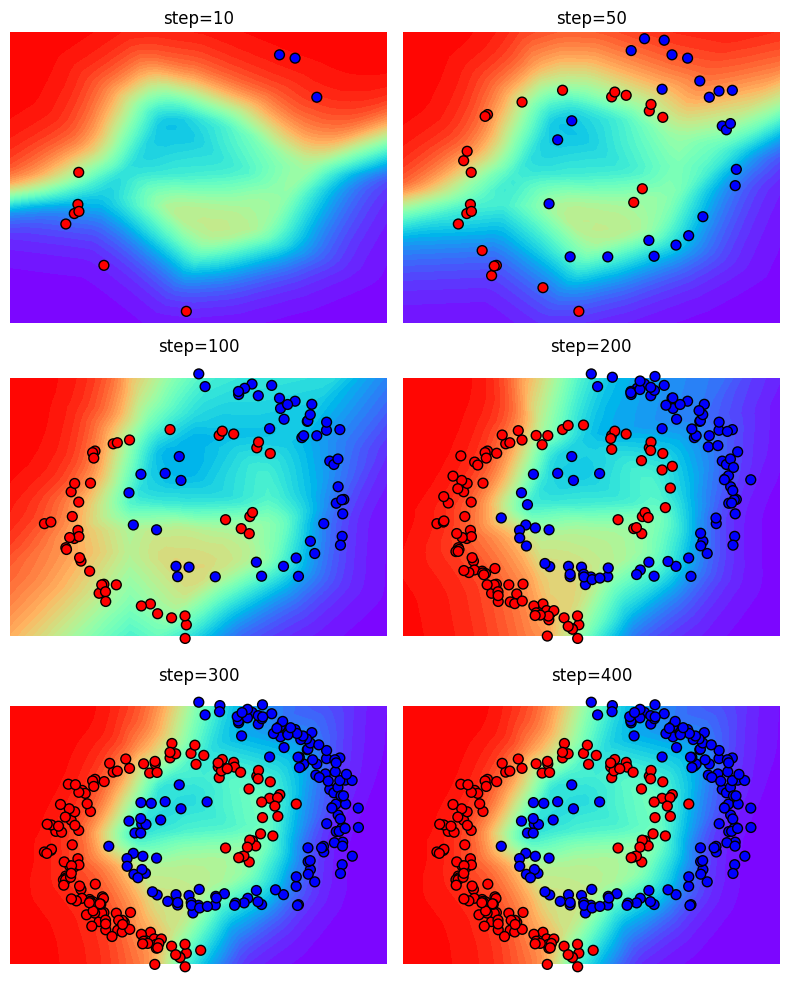

In [ ]:
intermediate_steps = [9, 49, 99, 199, 299, 399]
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for step, axi in zip(intermediate_steps, ax.flatten()):
    Zi = posterior_predictive_grid(input_grid, w_means_rot[step], sigmoid_fn)
    title = f'step={step+1}'
    plot_posterior_predictive(axi, input_rot[:step+1], output_rot[:step+1], title, input_grid, Zi)
plt.tight_layout()

Finally, we generate a video of the MLP-Classifier being trained.

In [ ]:
# cmgf_ekf_post_rot = conditional_moments_gaussian_filter(cmgf_params2, EKFIntegrals(), output_rot, inputs=input_rot)

# # Extract history of filtered weight values
# w_means_rot, w_covs_rot = cmgf_ekf_post_rot.filtered_means, cmgf_ekf_post_rot.filtered_covariances

# # Evaluate the trained MLP on input_grid
# Z_rot = posterior_predictive_grid(input_grid, w_means_rot[-1], sigmoid_fn, binary=False)

# # Plot the final result
# fig_rot, ax_rot = plt.subplots(figsize=(6, 5))
# title = "CMGF-EKF One-Pass Trained MLP Classifier"
# plot_posterior_predictive(ax_rot, input_rot, output_rot, title, input_grid, Z_rot);

In [ ]:
 import matplotlib.animation as animation
 from IPython.display import HTML

In [ ]:
def animateSpec(i):
  ax.cla()
  if i + 1 + 150>= 500:
    if (i+1 + 150)%2 == 0:
          w_curr = cmgf_ekf_post_rot.filtered_means[i - 499 + 150]
          Zi = posterior_predictive_grid(input_grid, cmgf_ekf_post_rot.filtered_means[i - 499 + 150], sigmoid_fn, binary=False)
          title = f'EKF-DDN (500/500) + Rotated data ({i - 499 + 150}/150)'
          plot_posterior_predictive(ax, input_rot[:i - 499], output_rot[:i - 499 + 150], title, input_grid, Zi);
          return ax
    else:
        #do nothing
        w_curr = cmgf_ekf_post_rot.filtered_means[i - 499 - 1 + 150]
        Zi = posterior_predictive_grid(input_grid, cmgf_ekf_post_rot.filtered_means[i - 499 -1 + 150], sigmoid_fn, binary=False)
        title = f'EKF-DDN (500/500) + Rotated data ({i - 499 - 1 + 150}/150)'
        plot_posterior_predictive(ax, input_rot[:i - 499 - 1 + 150], output_rot[:i - 499 - 1 + 150], title, input_grid, Zi);
        return ax
  w_curr = w_means[i + 150]
  Zi = posterior_predictive_grid(input_grid, w_means[i + 150], sigmoid_fn)
  title = f'EKF-DDN ({i+1+150}/500)'
  plot_posterior_predictive(ax, input[:i+1 + 150], output[:i+1 + 150], title, input_grid, Zi)
  return ax

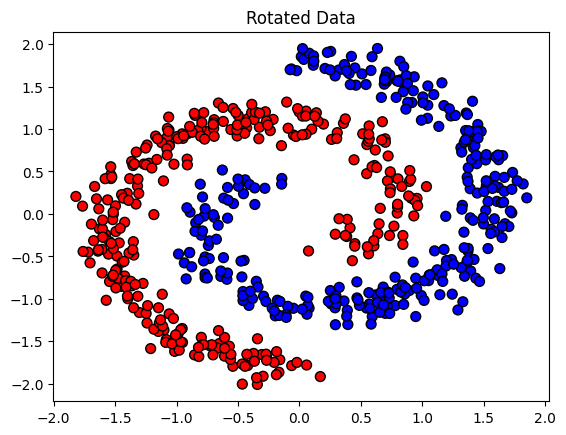

In [ ]:
#Generate extra rotated data for extended animation
def generate_rotated_dataset(rot = 0, key=0, num_per_class=250, zero_var=1., one_var=1., shuffle=True):
  input, output = generate_spiral_dataset(key, num_per_class, zero_var, one_var, shuffle)

  theta = 2.0*jnp.pi *rot/360.0
  rot_mat = jnp.array([[jnp.cos(theta), jnp.sin(theta)], [-jnp.sin(theta), jnp.cos(theta)]])
  input_rot = input @ rot_mat
  # input_rot_with_bias = jnp.concatenate([jnp.ones((num_per_class, 1)), input_rot], axis=1)

  return input_rot, output
# generate some rotated data

rot = 90 # in degrees
input_rot, output_rot = generate_rotated_dataset(rot = rot, num_per_class = 300)

# plot the data

fig, ax = plt.subplots()
title = 'Rotated Data'
plot_posterior_predictive(ax, input_rot, output_rot, title);


def animate(i):
  ax.cla()
  if i + 1 >= 500:
          w_curr = cmgf_ekf_post_rot.filtered_means[i - 499]
          Zi = posterior_predictive_grid(input_grid, cmgf_ekf_post_rot.filtered_means[i - 499], sigmoid_fn, binary=False)
          title = f'EKF-DDN (500/500) + Rotated data ({i - 499}/300)'
          plot_posterior_predictive(ax, input_rot[:i - 499], output_rot[:i - 499], title, input_grid, Zi);
          return ax
  w_curr = w_means[i]
  Zi = posterior_predictive_grid(input_grid, w_means[i], sigmoid_fn)
  title = f'EKF-DDN ({i+1}/500)'
  plot_posterior_predictive(ax, input[:i+1], output[:i+1], title, input_grid, Zi)
  return ax

In [ ]:
#def animate2(i):
#    ax.cla()
#    w_curr = w_means[i]
#    Zi = posterior_predictive_grid(input_grid, w_means[i], sigmoid_fn)
#    title = f'CMGF-EKF-MLP ({i+1}/500)'
#    plot_posterior_predictive(ax, input[:i+1], output[:i+1], title, input_grid, Zi)
#    return ax


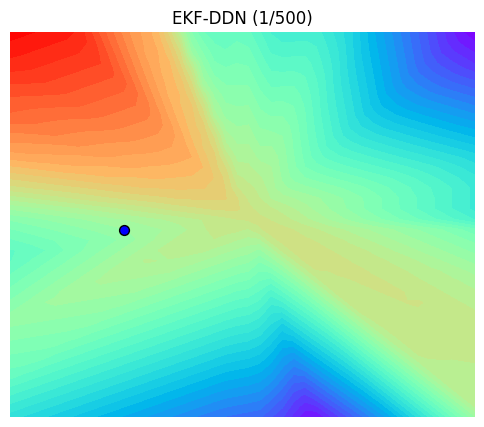

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
anim = animation.FuncAnimation(fig, animate, frames=800, interval=50)
anim.save("cmgf_mlp_classifier.mp4", dpi=200, bitrate=-1, fps=15)

In [ ]:
HTML(anim.to_html5_video())